In [8]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [9]:
import pandas as pd
from scripts.backtest.backtest_utils import backtest_portfolio

In [10]:
portfolio = pd.read_csv(
    "../data/processed/portfolio_returns.csv",
    index_col=0,
    parse_dates=True
)

In [16]:
raw_perf = backtest_portfolio(portfolio.raw_returns)
scaled_perf = backtest_portfolio(portfolio.scaled_returns)

pd.DataFrame([raw_perf, scaled_perf],
             index=["Unscaled", "Regime-Scaled"])


,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
Unscaled,0.063270,0.170592,0.370883,-0.346837
Regime-Scaled,0.096712,0.109205,0.885601,-0.134226


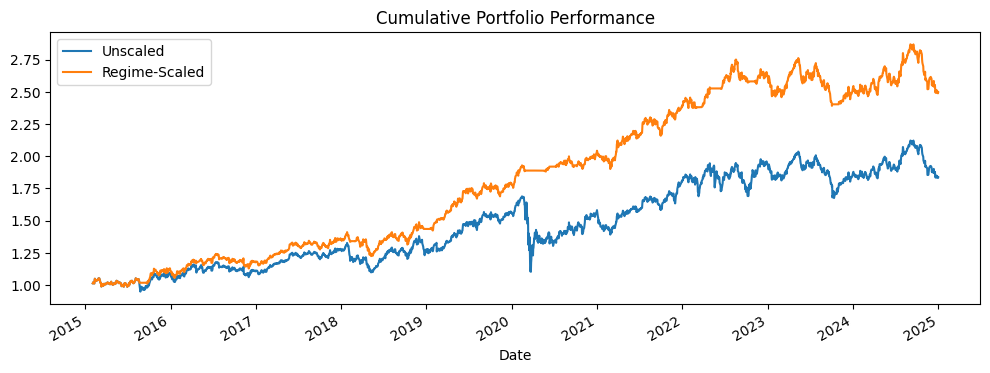

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
(1 + portfolio.raw_returns).cumprod().plot(label="Unscaled")
(1 + portfolio.scaled_returns).cumprod().plot(label="Regime-Scaled")
plt.legend()
plt.title("Cumulative Portfolio Performance")
plt.show()
